In [1]:
!pip install torch torchvision opencv-python matplotlib

Defaulting to user installation because normal site-packages is not writeable


In [7]:
import torch
import torchvision
from torchvision import transforms
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Helper function to preprocess images
def preprocess_image(image):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((1080, 940)),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])
    return transform(image).unsqueeze(0)

# Function to detect dominant color (white) within a bounding box
def is_white_shirt(box, frame):
    x1, y1, x2, y2 = box.int()
    cropped = frame[y1:y2, x1:x2]
    # Convert to HSV to detect white
    hsv_cropped = cv2.cvtColor(cropped, cv2.COLOR_BGR2HSV)
    
    # Define white color range in HSV
    lower_white = np.array([255, 255, 255], dtype=np.uint8)
    upper_white = np.array([215, 215, 215], dtype=np.uint8)
    
    # Create a mask to filter out white regions
    mask = cv2.inRange(hsv_cropped, lower_white, upper_white)
    white_ratio = cv2.countNonZero(mask) / (cropped.size / 3)  # Normalize by area
    
    return white_ratio > 0.5  # Adjust threshold as needed

In [8]:
# Load a Faster R-CNN model pretrained on the COCO dataset
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
model.eval()

/home/cmusfel1/.local/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/cmusfel1/.local/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [9]:
# Check if GPU is available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

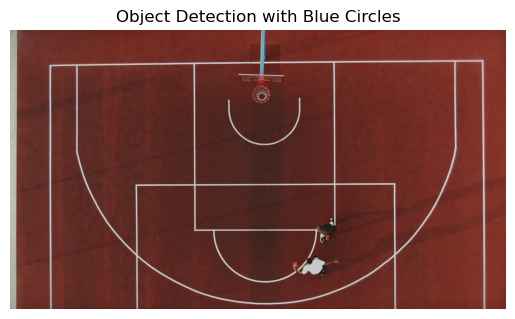

In [10]:
# Load video
video_path = "sample.mp4" 
cap = cv2.VideoCapture(video_path)

# Read the first frame
ret, frame = cap.read()

if ret:
    # Convert frame to PIL image
    image = Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    # Preprocess image
    image_tensor = preprocess_image(image).to(device)
    
    # Perform object detection
    with torch.no_grad():
        outputs = model(image_tensor)
    
    # Extract detections for the "person" class (label 1 in COCO)
    person_detections = [output for output in outputs[0]['boxes'][outputs[0]['labels'] == 1]]
    
    # Draw blue circles over detected persons
    for box in person_detections:
        x1, y1, x2, y2 = box.int()
        center_x = int((x1 + x2) / 2)
        center_y = int((y1 + y2) / 2)
        cv2.circle(frame, (center_x, center_y), radius=10, color=(255, 0, 0), thickness=-1)  # Blue color in BGR
    
    # Convert BGR (OpenCV) frame back to RGB for Matplotlib
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    
    # Display the frame with circles
    plt.imshow(frame_rgb)
    plt.axis('off')
    plt.title("Object Detection with Blue Circles")
    plt.show()

# Release the video capture
cap.release()

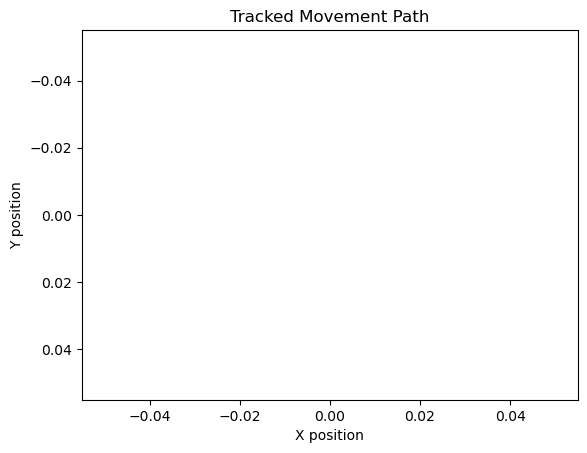

In [11]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the video file
video_path = "sample.mp4"
cap = cv2.VideoCapture(video_path)

# Parameters
scale_factor = 0.5  # Downscale factor for frames
frame_skip = 5      # Process every 5th frame
frame_limit = 100   # Max number of frames to process for testing

# Read the first two frames
ret, frame1 = cap.read()
if ret:
    frame1 = cv2.resize(frame1, (0, 0), fx=scale_factor, fy=scale_factor)

ret, frame2 = cap.read()
if ret:
    frame2 = cv2.resize(frame2, (0, 0), fx=scale_factor, fy=scale_factor)

# Prepare for tracking
tracking_points = []
frame_count = 0

while cap.isOpened() and frame_count < frame_limit:
    # Skip frames for lighter processing
    if frame_count % frame_skip == 0:
        # Calculate the absolute difference between the current frame and the next frame
        diff = cv2.absdiff(frame1, frame2)
        
        # Convert the difference image to grayscale
        gray = cv2.cvtColor(diff, cv2.COLOR_BGR2GRAY)
        
        # Apply Gaussian blur and thresholding
        blur = cv2.GaussianBlur(gray, (5, 5), 0)
        _, thresh = cv2.threshold(blur, 220, 255, cv2.THRESH_BINARY)
        
        # Dilate to fill in holes
        dilated = cv2.dilate(thresh, None, iterations=3)
        
        # Find contours
        contours, _ = cv2.findContours(dilated, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        
        # Track movement
        for contour in contours:
            if cv2.contourArea(contour) < 500:
                continue
            (x, y, w, h) = cv2.boundingRect(contour)
            center_x = x + w // 2
            center_y = y + h // 2
            tracking_points.append((center_x, center_y))
        
        # Update frames and resize
        frame1 = frame2
        ret, frame2 = cap.read()
        if ret:
            frame2 = cv2.resize(frame2, (0, 0), fx=scale_factor, fy=scale_factor)
        else:
            break

    frame_count += 1

cap.release()

# Plot the movement path after processing
x_points, y_points = zip(*tracking_points) if tracking_points else ([], [])
plt.plot(x_points, y_points, 'bo-', markersize=2, linewidth=1)
plt.gca().invert_yaxis()
plt.title("Tracked Movement Path")
plt.xlabel("X position")
plt.ylabel("Y position")
plt.show()

In [25]:
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt
from transformers import ViTFeatureExtractor, ViTForImageClassification

# Load ViT model and feature extractor
feature_extractor = ViTFeatureExtractor.from_pretrained("google/vit-base-patch16-224")
model = ViTForImageClassification.from_pretrained("google/vit-base-patch16-224")

# Set the model to evaluation mode
model.eval()

# Initialize device (GPU if available)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Load video
video_path = "sample.mp4"  # Replace with your video file path
cap = cv2.VideoCapture(video_path)

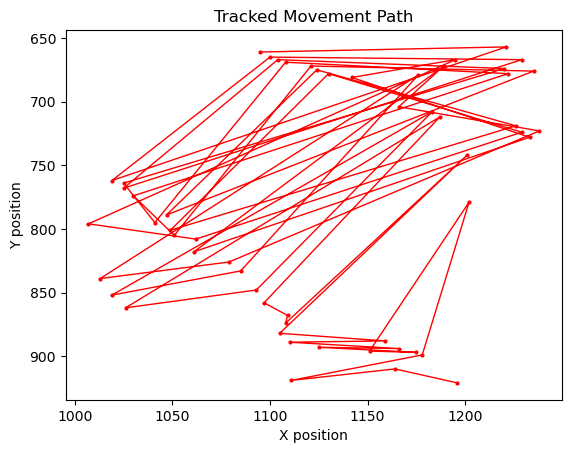

In [26]:
# Downscale factor for lighter processing
scale_factor = 0.5
frame_skip = 5
frame_limit = 100

# Read first two frames
ret, frame1 = cap.read()
if ret:
    frame1 = cv2.resize(frame1, (0, 0), fx=scale_factor, fy=scale_factor)

ret, frame2 = cap.read()
if ret:
    frame2 = cv2.resize(frame2, (0, 0), fx=scale_factor, fy=scale_factor)

# Track movement positions
movement_positions = []
frame_count = 0

while cap.isOpened() and frame_count < frame_limit:
    if frame_count % frame_skip == 0:
        # Calculate absolute difference between frames
        diff = cv2.absdiff(frame1, frame2)
        
        # Convert diff image to RGB and resize for ViT input
        diff_rgb = cv2.cvtColor(diff, cv2.COLOR_BGR2RGB)
        resized_diff = cv2.resize(diff_rgb, (224, 224))
        
        # Preprocess the image for ViT
        inputs = feature_extractor(images=resized_diff, return_tensors="pt").to(device)
        
        # Detect movement with ViT
        with torch.no_grad():
            outputs = model(**inputs)
            logits = outputs.logits
            predicted_class = logits.argmax(-1).item()
        
        # Define movement threshold (use frame differencing here)
        if predicted_class == 0:  # 0 class typically corresponds to 'no movement'
            pass
        else:
            # Find the moving region center
            gray_diff = cv2.cvtColor(diff, cv2.COLOR_BGR2GRAY)
            _, thresh = cv2.threshold(gray_diff, 30, 255, cv2.THRESH_BINARY)
            contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            
            for contour in contours:
                if cv2.contourArea(contour) < 500:
                    continue
                x, y, w, h = cv2.boundingRect(contour)
                center_x = x + w // 2
                center_y = y + h // 2
                movement_positions.append((center_x, center_y))
        
        # Prepare for next frame
        frame1 = frame2
        ret, frame2 = cap.read()
        if ret:
            frame2 = cv2.resize(frame2, (0, 0), fx=scale_factor, fy=scale_factor)
        else:
            break

    frame_count += 1

cap.release()

# Plot the movement path
if movement_positions:
    x_coords, y_coords = zip(*movement_positions)
    plt.plot(x_coords, y_coords, 'ro-', markersize=2, linewidth=1)
    plt.gca().invert_yaxis()
    plt.title("Tracked Movement Path")
    plt.xlabel("X position")
    plt.ylabel("Y position")
    plt.show()
else:
    print("No movement detected in the video.")

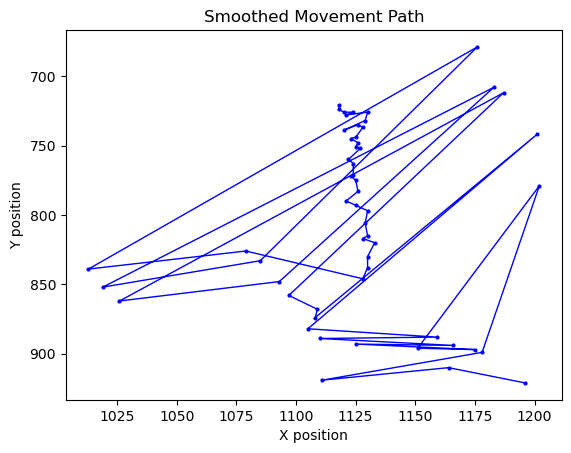

In [38]:
def smooth_path(points, window_size=25):
    smoothed_points = []
    for i in range(len(points)):
        if i < window_size:
            smoothed_points.append(points[i])
        else:
            avg_x = int(np.mean([p[0] for p in points[i - window_size:i]]))
            avg_y = int(np.mean([p[1] for p in points[i - window_size:i]]))
            smoothed_points.append((avg_x, avg_y))
    return smoothed_points

# Apply smoothing
smoothed_movement_positions = smooth_path(movement_positions)

# Plot the smoothed movement path
x_coords, y_coords = zip(*smoothed_movement_positions) if smoothed_movement_positions else ([], [])
plt.plot(x_coords, y_coords, 'bo-', markersize=2, linewidth=1)
plt.gca().invert_yaxis()
plt.title("Smoothed Movement Path")
plt.xlabel("X position")
plt.ylabel("Y position")
plt.show()

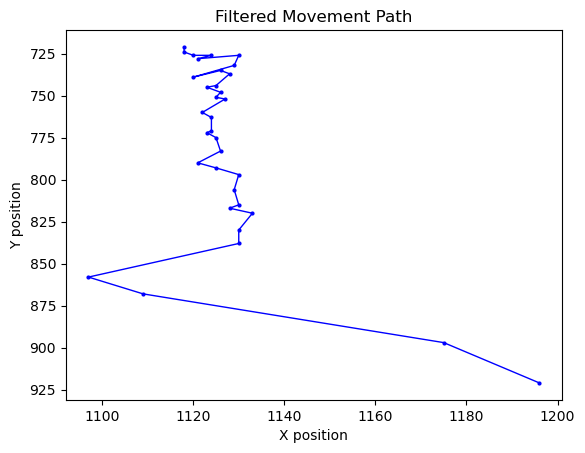

In [41]:
def filter_outliers(points, max_distance=30):
    filtered_points = [points[0]]
    for i in range(1, len(points)):
        dist = np.sqrt((points[i][0] - points[i-1][0])**2 + (points[i][1] - points[i-1][1])**2)
        if dist < max_distance:
            filtered_points.append(points[i])
    return filtered_points

# Apply outlier filtering
filtered_movement_positions = filter_outliers(smoothed_movement_positions)

# Plot the filtered movement path
x_coords, y_coords = zip(*filtered_movement_positions) if filtered_movement_positions else ([], [])
plt.plot(x_coords, y_coords, 'bo-', markersize=2, linewidth=1)
plt.gca().invert_yaxis()
plt.title("Filtered Movement Path")
plt.xlabel("X position")
plt.ylabel("Y position")
plt.show()